## Project
With this project we aim to implement two data mining methods to predict ancestry based on SNPs (Single Nucleotide Polymorphisms). The selection of SNPs to use are based on certain SNP sets from existing research, these are typically called AIM (Acestry Informative Markers).
The first method we implement is a machine learning algorithm: Random Forest.

## Data

### VCF file
The data is from the 1000 genomes project, it contains 2500 samples and 84.4 million SNPs. It is available in VCF (variant call format). This contains the following information:

|CHROM|POS|ID|REF|ALT|QUAL|FILTER|INFO|FORMAT|NA00001|NA00002|NA00003|
|-----|---|--|---|---|----|------|----|------|-------|-------|-------|
|20|14370|rs6054257|G|A|29|PASS|NS=3|GT|0\|0|1\|0|1/1|
|20|17330|rs3409304|T|A|3|q10|NS=3|GT|0\|0|0\|1|0/0|


The columns relevent for us are:
 - ID: an id to index the features
 - NA00001, NA00002, ... : the sample genotypes, these are all the individual samples with the corresponding features (the genotypes) <br>

So, on each row there is an individual feature, and from column 10 onward there are the genotypes listed per sample (separated by tab. <br>
Few examples of the genotype format:
 - 0|1 
 - 0/1
 - 1|2
    
| : the genotypes are phased, the paternal and maternal alleles are listed in a particualar order (e.g.: paternal|maternal) <br>
/ : the genotypes are unphased, the order or the alleles are not consistent. <br>
0 : the reference allele, in the above example this is G. <br>
1 : the alternative allele, in the above example this is A. <br>
2 : the second alternative allele, this can go up to 6, but typically there is only one alternative allele. <br>
    
The individual samples in the vcf file (NA00001, NA00002, ...) have a certain ancestry, this is listed in a separate file

### Sample file

|Sample name|Sex|Biosample ID|Population code|Population name|Superpopulation code|Superpopulation name|Data collections|
|-----------|---|------------|---------------|---------------|--------------------|--------------------|----------------|
|NA00001|female|SAME123271|GBR|British|EUR|European|1000 Genomes on GRCh38,1000 Genomes phase 3 release,1000 Genomes phase 1 release,Geuvadis|
|NA00002|male|SAME123268|GBR|British|EUR|European|1000 Genomes on GRCh38,1000 Genomes phase 3 release,1000 Genomes phase 1 release,Geuvadis|

The columns relevant to us are: 
 - Sample name: names corresponding to the sample names in the VCF file
 - (Super)population code. We can construct a model based on the Population code (country) or Superpopulation code (continent) to predict ancestry. <br>
    
Even though the population code is more specific, the superpopulation is much easier to accurately predict.


### AIM files

Before training the model, we needed to make a subselection from the 84.4 million SNPs. We have done this by searching for relevant papers concerning AIM sets developed to classify global ancestry. Many had a file containing the selected SNPs marked with rs IDs (unique SNP identifiers from dbSNP) available for download. This search resulted in 5 AIM files with various amounts of SNPs (100 to 400). Finally we extracted the genotypes from the 2500 individuals (samples) for these particular SNP sets (by rsID) by iterating through the 1000 Genomes vcf files and copying the relevant data to new vcf files.
<br>

### Results

The Random Forest model performs with a baseline score of 96.85% (10k-fold cross validation) <br>
Other scores can be found below (see classification report) <br><br>


In [2]:
import gzip
import pandas

vcf_file = "Data/aim_geno/panel_snps.txt"
vcf = open(vcf_file, 'r')

# if the VCF is big, we van prevent flooding the memory by reading the file line by line
go = True
while go:
    line = vcf.readline()
#     line = line.decode('utf-8')
    # this line contains the headers and also all the sample names
    if line.startswith('#C'):
        split_line = line.split('\t')

        samples = split_line[9:]
        samples[-1] = samples[-1].strip('\n')
        break

# sort samples on their ID
samples = sorted(samples)
# index the data frame on the sample names, this is convenient for merging later on
samples_idx = pandas.DataFrame(index=samples)

In [3]:
# ignore SettingWithCopyWarning errors
pandas.options.mode.chained_assignment = None  # default='warn'
# file containing all the sample labels (the population codes)
popfile = "Data/igsr_samples.tsv"

with open(popfile, 'r') as pop:
    pop_df = pandas.read_csv(pop, sep='\t', header=0)

# select the sample names and population codes to make a new data frame
pop_class = pop_df[['Sample name', 'Population code']]

# select the sample names and superpopulation codes to make a new data frame
superpop_class = pop_df[['Sample name','Superpopulation code']]

# set the sample names as index of pandas dataframe 
superpop_class.set_index('Sample name', inplace=True)
superpop_class.sort_index(inplace=True)

# create a new data frame by merging the label information with the existing sample IDs
feature_labels = samples_idx.join(superpop_class)

In [4]:
# check how many samples per label are present in the data
class_ratios = feature_labels['Superpopulation code'].value_counts()
print(class_ratios)

AFR    661
EAS    504
EUR    503
SAS    489
AMR    347
Name: Superpopulation code, dtype: int64


In [5]:
import numpy as np

opened = open(vcf_file, 'r')

samples = samples_idx

cnt = 0
line = True
while line:
    line = opened.readline()

    if not line.startswith('#') and line.strip():
        # extract the sample genotypes from the row
        rs_id = line.split('\t')[2]
        alleles = line.split('\t')[9:]
        alleles[-1] = alleles[-1].strip('\n')

        # label missing data as NAN
        alleles = [x if not '.' in x.split('|') else np.NAN for x in alleles]
        
        # put the genotype info in certain order, i.e. the phasing is disregarded
        alleles = ['|'.join(sorted(x.split('|'))) for x in alleles if x is not np.NAN]
        
        # add the feature (SNP) to the existing data frame
        samples[rs_id] = alleles

        cnt += 1

opened.close()

# drop the columns (features) with NAN values
samples.dropna(axis=0, thresh=1, how="any", inplace=True)

# covert the categorical data (e.g. 1|0, 1|2) to numerical by one-hot-encoding
features_df = pandas.get_dummies(samples)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

features = np.array(features_df)
labels = np.array(feature_labels).ravel()

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25,
                                                                            random_state=42)

In [6]:
# do hyperparameter tuning on with RandomForestClassifier on our data set

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
param_grid = { "criterion" : ["gini", "entropy"] , "min_samples_leaf" : [1,20,25,50], "min_samples_split" : [2,12,25], "n_estimators": [500, 1000, 1500]}
from sklearn.model_selection import GridSearchCV, cross_val_score

# define random forest model
rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=42, n_jobs=-1)
# method to test out all the combinations of the parameters
clf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, return_train_score=True)

# fit the features and labels 
clf.fit(train_features, train_labels)
# print the best parameters
clf.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 1500}

In [7]:
#redefine model with optimal parameters
rf = RandomForestClassifier(n_estimators=1500, criterion='gini', min_samples_leaf=1, min_samples_split=12, max_features='auto', oob_score=True, random_state=42, n_jobs=-1)

In [45]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# use k-fold cross-validation to compute a robust score for the model
# fix random seed for reproducibility
seed = 8
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(rf, features, labels, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 97.01% (0.86%)


In [8]:
# Use traditional train-test-split to compare with K-fold cross validation baseline and make classification report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

feature_list = features_df.columns


# print dimensions to check if all is ok
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

train_labels = train_labels.ravel()

# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

Training Features Shape: (1878, 492)
Training Labels Shape: (1878,)
Testing Features Shape: (626, 492)
Testing Labels Shape: (626,)


In [9]:
# print scores and classification report

# change dimension of labels to compute accuracy
test_labels = test_labels.ravel()
accuracy = accuracy_score(test_labels, predictions)

print('accuracy: {}'.format(round(accuracy, 4)))

# print score ()
score = rf.score(train_features, train_labels)
print('score: {}'.format(round(score, 4)))

# print classification report
print(classification_report(test_labels, predictions))

accuracy: 0.9728
score: 0.9973
              precision    recall  f1-score   support

         AFR       0.99      0.98      0.98       168
         AMR       0.95      0.86      0.90        88
         EAS       1.00      1.00      1.00       137
         EUR       0.94      0.99      0.96       117
         SAS       0.97      1.00      0.98       116

   micro avg       0.97      0.97      0.97       626
   macro avg       0.97      0.97      0.97       626
weighted avg       0.97      0.97      0.97       626



In [10]:
# Import tools needed for visualization
import pydot
from sklearn.tree import export_graphviz


# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]
# export_graphviz(tree_small)

dotfile = open('tree_viz/small_tree.dot', 'w')
# Save the tree as a png image
export_graphviz(tree_small, out_file = dotfile, feature_names = feature_list, rounded = True, precision = 1)
dotfile.close()

(graph, ) = pydot.graph_from_dot_file('tree_viz/small_tree.dot')

graph.write_png('tree_viz/small_tree.png')

In [11]:
# generate dataframe for feature importance
# visualizes which SNPs may be exluded from the model to prevent overfitting (print with 165 to see top and bottom SNPs)
# since these are one-hot-encoded, all the allele variants need to be in the be in the same ranking to determine if they can be discarded
feature_importances = pandas.DataFrame(rf.feature_importances_,
                                   index = feature_list,
                                    columns=['importance']).sort_values('importance', ascending=False)

# write out most important snps, check for duplicates (same snp, different allele variant)
snps = feature_importances.index.values
most_important = []

for snp in snps:
    snp = snp.split('_')[0]
    if snp not in most_important:
        most_important.append(snp)
    if len(most_important) == 10:
        break

with open('output/10_important_snps.txt', 'w') as out:
    out.write('\n'.join(most_important))
    
with open('output/all_snp_importance.txt', 'w') as out:
    out.write('\n'.join(snps))

[]

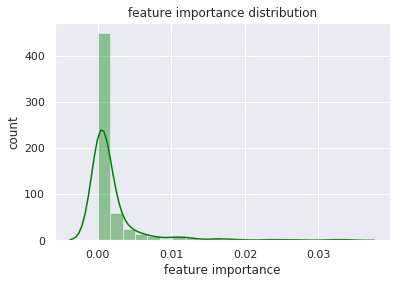

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

feat_imp = pandas.Series(feature_importances.importance)

sns.set(color_codes=True)

ax = sns.distplot(feat_imp, bins=20, color='green')
ax.set(xlabel='feature importance', ylabel='count', title='feature importance distribution')
ax.plot()

<Figure size 432x288 with 0 Axes>

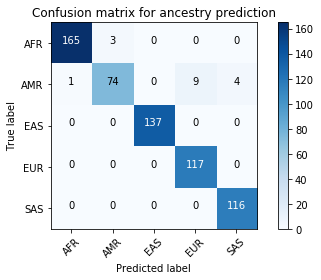

<Figure size 432x288 with 0 Axes>

In [29]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import itertools
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predictions)

# borrowed function from sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    


target_names = sorted(list(set(list(labels.ravel()))))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix for ancestry prediction')
plt.figure()